<a href="https://colab.research.google.com/github/MorenoSara/Few-Shot_Text_Classification/blob/main/Few_shot_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U sentence-transformers

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
from sentence_transformers.util import cos_sim
import numpy as np
import scipy
import random

random_seed = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)

### Load data

In [3]:
train_dataset = pd.read_excel('train.xlsx', index_col=0) # 32889 samples
train_dataset.head(10)

Y1  Y2    Y         Domain                          area  \
0   5  43  115       Medical          Parkinson's Disease     
1   0   1    1            CS             Machine learning     
2   0   7    7            CS           Parallel computing     
3   6   6  131  biochemistry    Polymerase chain reaction     
4   6   6  131  biochemistry    Polymerase chain reaction     
5   3   1   53           MAE                   Hydraulics     
6   6   2  127  biochemistry             Human Metabolism     
7   2   7   40   Psychology                    Depression     
8   0   4    4            CS            Operating systems     
9   2   4   37   Psychology            Prosocial behavior     

                                            keywords  \
0   deep brain stimulation; basal ganglia; parkin...   
1   Supervised classification; Label ranking prob...   
2   Track fitting; Track reconstruction; Multiple...   
3   bacterial community; calves; probiotics; rume...   
4   Bladder cancer; glycoprotein nonmetastatic me...   
5   Groundwater hydraulics; Aquitard; Bangladesh;...   
6   BORON; MANGANESE; MEMBRANES; CELL WALLS; NADH...   
7   putamen; basal ganglia; magnetic resonance im...   
8   Wireless sensor networks; localized interacti...   
9   Eye contact effects; Therapeutic implications...   

                                            Abstract  
0  The subthalamic nucleus (STN) and globus palli...  
1  Preference learning is the branch of machine l...  
2  Modern semiconductor detectors allow for charg...  
3  The objective of this study was to assess the ...  
4  Glycoprotein nonmetastatic melanoma protein B ...  
5  Identifying flow processes in multi-aquifer fl...  
6  Boron has been recognized since 1923 as an ess...  
7  Putamen volume is seen to alter in neurologica...  
8  Wireless sensor networks (WSNs) are characteri...  
9  Introduction. The perception of a direct gaze ...

In [4]:
REMAP_LEV1 = {'CS': 'Computer Science', 
              'Civil': 'Civil Engineering', 
              'ECE': 'Electrical Engineering', 
              'Psychology': 'Psychology', 
              'MAE': 'Mechanical Engineering', 
              'Medical': 'Medical Science', 
              'biochemistry': 'Biochemistry'}

In [5]:
def get_mapped_labels(data, mapping_dict):
  labels = [l.strip() for l in data]
  return list(map(lambda l: mapping_dict[l], labels))

In [6]:
labels = get_mapped_labels(set(train_dataset['Domain']), REMAP_LEV1)
abstracts = train_dataset['Abstract']

In [7]:
labels

['Computer Science',
 'Civil Engineering',
 'Medical Science',
 'Electrical Engineering',
 'Mechanical Engineering',
 'Psychology',
 'Biochemistry']

### Compute entropy

In [8]:
st_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = device)

In [9]:
labels_embeddings = st_model.encode(labels)
# doc_embeddings = st_model.encode(abstracts, batch_size = 256, show_progress_bar=True) # directly encode the entire documents 

In [10]:
#with open('doc_embeddings.txt','wb') as f:
    #for line in np.matrix(doc_embeddings):
        #np.savetxt(f, line)

In [11]:
df = pd.read_csv('/content/drive/MyDrive/doc_embeddings.txt', sep = ' ', header=None) 
# retrieve corresponding document using train_dataset.iloc[i]

In [12]:
def floored_cosine_tensors(X, Y):
  sim = cos_sim(X, Y)
  return np.maximum(0, sim)

In [13]:
def get_entropies(sentences, labels_embeddings):
  probs = floored_cosine_tensors(sentences, labels_embeddings)
  print
  normalized_probs = probs/np.linalg.norm(probs, axis = 1).reshape(-1,1)
  normalized_entropy = scipy.stats.entropy(normalized_probs, axis = 1)/np.log(labels_embeddings.shape[0])
  print(normalized_entropy.shape)
  return normalized_entropy

In [14]:
df = df.astype(np.float32)
doc_embeddings = np.matrix(df)
entropies = get_entropies(doc_embeddings, labels_embeddings)

(32889,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [15]:
train_df = train_dataset
train_df['Entropy'] = entropies
train_df['Domain'] = get_mapped_labels(train_df['Domain'], REMAP_LEV1)
train_df.dropna(inplace=True)
train_df


Y1  Y2    Y                  Domain                          area  \
0       5  43  115         Medical Science         Parkinson's Disease     
1       0   1    1        Computer Science            Machine learning     
2       0   7    7        Computer Science          Parallel computing     
3       6   6  131            Biochemistry   Polymerase chain reaction     
4       6   6  131            Biochemistry   Polymerase chain reaction     
...    ..  ..  ...                     ...                           ...   
32884   5  26   98         Medical Science                    HIV/AIDS     
32885   3   3   55  Mechanical Engineering              Machine design     
32886   2  18   51              Psychology             Problem-solving     
32887   5  41  113         Medical Science          Overactive Bladder     
32888   4   7   68       Civil Engineering              Green Building     

                                                keywords  \
0       deep brain stimulation; basal ganglia; parkin...   
1       Supervised classification; Label ranking prob...   
2       Track fitting; Track reconstruction; Multiple...   
3       bacterial community; calves; probiotics; rume...   
4       Bladder cancer; glycoprotein nonmetastatic me...   
...                                                  ...   
32884   Biomarkers; Cytokine; HIV; Gingival crevicula...   
32885   Red Catuai; Poisson's ratio; density; elastic...   
32886   health care issues; health care utilization; ...   
32887   attentional and interoceptive networks; brain...   
32888       Green building; Information modeling           

                                                Abstract   Entropy  
0      The subthalamic nucleus (STN) and globus palli...  0.577499  
1      Preference learning is the branch of machine l...  0.784086  
2      Modern semiconductor detectors allow for charg...  0.543961  
3      The objective of this study was to assess the ...  0.358490  
4      Glycoprotein nonmetastatic melanoma protein B ...  0.337900  
...                                                  ...       ...  
32884  Objective: This study evaluates the potential ...  0.349118  
32885  The finite element method has been employed in...  0.766171  
32886  The University Hospital of Zurich offers a tex...  0.699593  
32887  BACKGROUND: Treatment of urgency urinary incon...  0.828843  
32888  The objective of this paper is to explore BIM ...  0.793714  

[32797 rows x 8 columns]

Create a dataframe for each label

In [16]:
dfs = {}
for label in labels:
  dfs[f"{label.replace(' ', '_')}"] = train_df[train_df['Domain'] == label]

In [17]:
from torch.utils.data.dataset import Dataset
class document_class(Dataset):
  def __init__(self, documents, labels):
    self.train_df = []
    for id, doc in enumerate(documents):
      curr_doc = [labels[id]]
      curr_doc.append(doc) 
      self.train_df.append(curr_doc)
  
  def __getitem__(self, index):
    return self.train_df[index] 

  def __len__(self):
    return len(self.train_df)

In [18]:
def my_collate_fn(batch):
  documents = []
  labels = []
  for doc in batch:
    documents.append(doc[1])
    labels.append(list(doc[0]))
  return (documents, torch.Tensor(labels))

In [19]:
def save_model(model, model_path):
    """Save model."""
    torch.save(model.state_dict(), model_path)

def load_model(model, model_path, use_cuda=True):
    """Load model."""
    map_location = 'cpu'
    if use_cuda and torch.cuda.is_available():
        map_location = 'cuda:0'
    model.load_state_dict(torch.load(model_path, map_location))
    return model

# Models

In [20]:
from torch import nn
class FreezeSTTrainClassifier(nn.Module):
  def __init__(self, sentence_transformer_model, st_embedding_dimension, num_classes, device, dropout = 0.3):
    super().__init__()
    self.st = SentenceTransformer(sentence_transformer_model)
    for param in self.st.parameters():
      param.requires_grad = False
    self.classification = nn.Linear(in_features=st_embedding_dimension, out_features=num_classes)
    torch.nn.init.eye_(self.classification.weight)
    torch.nn.init.zeros_(self.classification.bias)
    self.device = device
    self.dropout = nn.Dropout(dropout)
    self.to(device)

  def forward(self, documents):
    with torch.no_grad():
      docs = self.st.encode(documents, convert_to_tensor=True) # exploit pretrained sentence transformer
    docs = self.dropout(docs)
    probs = self.classification(docs) # assign a score to each class for every document
    return probs

In [21]:
from torch import nn
class Classifier(nn.Module):
  def __init__(self, in_dim, out_dim, device, dropout = 0.3):
    super().__init__()
    self.classification = nn.Linear(in_features=in_dim, out_features=out_dim)
    torch.nn.init.eye_(self.classification.weight)
    torch.nn.init.zeros_(self.classification.bias)
    self.device = device
    self.dropout = nn.Dropout(dropout)
    self.to(device)

  def forward(self, documents_embeddings):
    docs = self.dropout(documents_embeddings)
    scores = self.classification(docs) # assign a score to each class for every document
    return scores

# Few-shot text classification
Works also for one shot classification

In [ ]:
N_shots = 1# number of examples for each class

### Random

In [23]:
from numpy.random import choice

def random_selection(dfs, N_shots):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      N_shots_data.append(dfs[k].iloc[choice(len(ordered), N_shots, replace = False)]) # sort the values according to their entropy 
  dataframes = pd.concat(N_shots_data).reset_index(drop=True)
  return dataframes

In [ ]:
dataframes = random_selection(dfs, N_shots)
dataframes

Y1  Y2    Y                  Domain                         area  \
0   6   0  125            Biochemistry          Molecular biology     
1   3   4   56  Mechanical Engineering            Fluid mechanics     
2   4   5   66       Civil Engineering          Suspension Bridge     
3   0   1    1        Computer Science           Machine learning     
4   5  29  101         Medical Science   Irritable Bowel Syndrome     
5   2  14   47              Psychology                Child abuse     
6   1  12   29  Electrical Engineering          Signal-flow graph     

                                            keywords  \
0   Supercritical; Enzyme; Modification; Stabiliz...   
1   Time-dependent fluid penetration; Capillary a...   
2   Sri Lanka; suspension bridge; jungle; develop...   
3   Protein-ligand binding; Scoring function; Imp...   
4   Complementary therapy; Healing; Spiritual hea...   
5   Violence Against Women; Spouse Abuse; Domesti...   
6   Sigma Delta modulator; signal flow graph; noi...   

                                            Abstract   Entropy  
0  In spite of excellent properties of supercriti...  0.000437  
1  This article addresses a classical fluid mecha...  0.845229  
2  Students from Karlsruhe University initiate, p...  0.811596  
3  Wconfirms the accuracy and robustness of the p...  0.714499  
4  Introduction: To determine the benefits of hea...  0.532028  
5  OBJECTIVE: The objective of this study is to a...  0.843749  
6  Sigma-delta modulator structure is presented i...  0.277066

### Entropy

In [24]:
def entropy(dfs, N_shots, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2]
      ordered_embeddings = st_model.encode(list(ordered['Abstract']), batch_size = 256, show_progress_bar=True) # compute the documents embeddings

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 
      # select the document with the highest entropy
        first = ordered.iloc[0] # the first element has the highest entropy
        N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
        N_shots_embeddings.append(ordered_embeddings[0])
        ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
        ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [78]:
dataframes = entropy(dfs, 3)
dataframes

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Y1  Y2    Y                  Domain                           area  \
0    4   9   70       Civil Engineering      Construction Management     
1    4   2   63       Civil Engineering               Remote Sensing     
2    4   3   64       Civil Engineering         Rainwater Harvesting     
3    1  13   30  Electrical Engineering   State space representation     
4    1  14   31  Electrical Engineering               PID controller     
5    1  14   31  Electrical Engineering               PID controller     
6    5   9   81         Medical Science                    Skin Care     
7    5  22   94         Medical Science                Healthy Sleep     
8    5  51  123         Medical Science          Sprains and Strains     
9    6   3  128            Biochemistry                   Immunology     
10   6   3  128            Biochemistry                   Immunology     
11   6   0  125            Biochemistry            Molecular biology     
12   3   1   53  Mechanical Engineering                   Hydraulics     
13   3   0   52  Mechanical Engineering        computer-aided design     
14   3   4   56  Mechanical Engineering              Fluid mechanics     
15   0   7    7        Computer Science           Parallel computing     
16   0   0    0        Computer Science              Computer vision     
17   0   0    0        Computer Science              Computer vision     
18   2   0   33              Psychology                    Prejudice     
19   2   4   37              Psychology           Prosocial behavior     
20   2  18   51              Psychology              Problem-solving     

                                             keywords  \
0    Construction management; Health hazards; Cons...   
1    Drought monitoring; crop yield; vegetation co...   
2    Rainwater harvesting; Irrigation; Langevin eq...   
3    Fuzzy transform; Concentrated solar collector...   
4    8 DOF; Fuzzy logic controller; Integrated sea...   
5    Meta-heuristic algorithm; Optimization; Conti...   
6    Early mobility in intensive care unit; Mobili...   
7    breathing; sleep stages; autonomic regulation...   
8    cadaver; muscles; rehabilitation; sprains and...   
9    time-delay; cancer immunotherapy; gene-regula...   
10   Laboratory Medicine; Medical Biochemistry; ed...   
11   curriculum design    development    and imple...   
12   fine roots; native embolism; refilling; starc...   
13   computer-aided design tools; design automatio...   
14   High frame rate; interferometry; drop impact;...   
15   Fast fuzzy c-means algorithm; Image segmentat...   
16   cell division rate; computer vision; elementa...   
17   environmental and climatic factors; eye sympt...   
18   highly skilled labor migration; Sweden; Japan...   
19   Materialism; Wellbeing; Epistemic style; Meta...   
20   TRIZ; Complexity; Power quality; Guidance fra...   

                                             Abstract   Entropy  
0   A theory-based intervention strategy to improv...  0.799878  
1   Drought is a natural climatic phenomenon that ...  0.799610  
2   A generic rainwater harvesting system includin...  0.799385  
3   This paper deals with the control of concentra...  0.799784  
4   Passenger travel comfort is important while an...  0.799771  
5   This paper presents a new optimization algorit...  0.799436  
6   BACKGROUND: Pressure ulcer formation continues...  0.799966  
7   Healthy sleep can be characterized by several ...  0.799947  
8   Objectives: To measure the strain on 3 fiber g...  0.799799  
9   In this paper, we analyse the local stability ...  0.798928  
10  Medical biochemistry is the usual name for cli...  0.798081  
11  This work describes a 10-week laboratory proje...  0.795536  
12  Restoration of an adequate water supply in spr...  0.799582  
13  The topic of this article is the development o...  0.799300  
14  The simple phenomenon of a water drop falling ...  0.798510  
15  The research on underwater image segmentation ...  0.799874 

### Distance

In [25]:
def distance(dfs, N_shots, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2]
      ordered_embeddings = st_model.encode(list(ordered['Abstract']), batch_size = 256, show_progress_bar=True) # compute the documents embeddings

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['distance'] = np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy * Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['distance']) # retrieve the id of the documnet with the highest distance*entropy
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['distance'] = np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy * Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance'])].to_dict()]) # retrieve the data of the document with the highest Entropy*Distance
        N_shots_data.append(top) # save it

  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [ ]:
dataframes = distance(dfs, N_shots)
dataframes

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Y1  Y2    Y                  Domain                           area  \
0   6   3  128            Biochemistry                   Immunology     
1   3   1   53  Mechanical Engineering                   Hydraulics     
2   4   9   70       Civil Engineering      Construction Management     
3   0   7    7        Computer Science           Parallel computing     
4   5   9   81         Medical Science                    Skin Care     
5   2   0   33              Psychology                    Prejudice     
6   1  13   30  Electrical Engineering   State space representation     

                                            keywords  \
0   time-delay; cancer immunotherapy; gene-regula...   
1   fine roots; native embolism; refilling; starc...   
2   Construction management; Health hazards; Cons...   
3   Fast fuzzy c-means algorithm; Image segmentat...   
4   Early mobility in intensive care unit; Mobili...   
5   highly skilled labor migration; Sweden; Japan...   
6   Fuzzy transform; Concentrated solar collector...   

                                            Abstract   Entropy  
0  In this paper, we analyse the local stability ...  0.798928  
1  Restoration of an adequate water supply in spr...  0.799582  
2  A theory-based intervention strategy to improv...  0.799878  
3  The research on underwater image segmentation ...  0.799874  
4  BACKGROUND: Pressure ulcer formation continues...  0.799966  
5  As labor markets become increasingly global, c...  0.799836  
6  This paper deals with the control of concentra...  0.799784

### Entropy * Distance from centroid

In [26]:
def distance_times_entropy(dfs, N_shots, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2] 
      ordered_embeddings = st_model.encode(list(ordered['Abstract']), batch_size = 256, show_progress_bar=True) # compute the documents embeddings

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['distance*entropy'] = ordered['Entropy']*np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy * Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['distance*entropy']) # retrieve the id of the documnet with the highest distance*entropy
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['distance*entropy'] = ordered['Entropy']*np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy * Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance*entropy'])].to_dict()]) # retrieve the data of the document with the highest Entropy*Distance
        N_shots_data.append(top) # save it

  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [79]:
dataframes = distance_times_entropy(dfs, 3)
dataframes

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Y1  Y2    Y                  Domain                           area  \
0    4   9   70       Civil Engineering      Construction Management     
1    4   3   64       Civil Engineering         Rainwater Harvesting     
2    4   9   70       Civil Engineering      Construction Management     
3    1  13   30  Electrical Engineering   State space representation     
4    1   0   17  Electrical Engineering                  Electricity     
5    1  14   31  Electrical Engineering               PID controller     
6    5   9   81         Medical Science                    Skin Care     
7    5  51  123         Medical Science          Sprains and Strains     
8    5  22   94         Medical Science                Healthy Sleep     
9    6   3  128            Biochemistry                   Immunology     
10   6   0  125            Biochemistry            Molecular biology     
11   6   3  128            Biochemistry                   Immunology     
12   3   1   53  Mechanical Engineering                   Hydraulics     
13   3   0   52  Mechanical Engineering        computer-aided design     
14   3   8   60  Mechanical Engineering        Strength of materials     
15   0   7    7        Computer Science           Parallel computing     
16   0   0    0        Computer Science              Computer vision     
17   0  15   15        Computer Science              Data structures     
18   2   0   33              Psychology                    Prejudice     
19   2  18   51              Psychology              Problem-solving     
20   2   0   33              Psychology                    Prejudice     

                                             keywords  \
0    Construction management; Health hazards; Cons...   
1    Rainwater harvesting; Irrigation; Langevin eq...   
2    Materiality; matter; material agency; socioma...   
3    Fuzzy transform; Concentrated solar collector...   
4    Gas; Electricity; Demand; Manufacturing secto...   
5    8 DOF; Fuzzy logic controller; Integrated sea...   
6    Early mobility in intensive care unit; Mobili...   
7    cadaver; muscles; rehabilitation; sprains and...   
8    breathing; sleep stages; autonomic regulation...   
9    time-delay; cancer immunotherapy; gene-regula...   
10   Cardiac optogenetics; Channelrhodopsin-2; Car...   
11   Laboratory Medicine; Medical Biochemistry; ed...   
12   fine roots; native embolism; refilling; starc...   
13   computer-aided design tools; design automatio...   
14   Defects; Fracture; Stress concentrations; Com...   
15   Fast fuzzy c-means algorithm; Image segmentat...   
16   cell division rate; computer vision; elementa...   
17   Data structures; Suffix array; LCP array; Lin...   
18   highly skilled labor migration; Sweden; Japan...   
19   cognitive aging; cortical surface area; corti...   
20                    AIDS; HIV; patient care           

                                             Abstract   Entropy  \
0   A theory-based intervention strategy to improv...  0.799878   
1   A generic rainwater harvesting system includin...  0.799385   
2   The increased interest for materiality as an a...  0.798634   
3   This paper deals with the control of concentra...  0.799784   
4   A comparative analysis of electricity and gas ...  0.798484   
5   Passenger travel comfort is important while an...  0.799771   
6   BACKGROUND: Pressure ulcer formation continues...  0.799966   
7   Objectives: To measure the strain on 3 fiber g...  0.799799   
8   Healthy sleep can be characterized by several ...  0.799947   
9   In this paper, we analyse the local stability ...  0.798928   
10  Optogenetics is a technique exploded in the la...  0.792428   
11  Medical biochemistry is the usual name for cli...  0.798081   
12  Restoration of an adequate water supply in spr...  0.799582   
13  The topic of this article is the development o...  0.799300   
14  This work is about the hypothesis of structura...  0.798169   
15  The research on underwater image segmentatio

### Entropy + Distance from centroid

In [25]:
def distance_plus_entropy(dfs, N_shots, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2]  
      ordered_embeddings = st_model.encode(list(ordered['Abstract']), batch_size = 256, show_progress_bar=True) # compute the documents embeddings

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['distance+entropy'] = ordered['Entropy']+np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy + Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['distance+entropy']) # retrieve the id of the documnet with the highest distance*entropy
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['distance+entropy'] = ordered['Entropy']+np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy + Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance+entropy'])].to_dict()]) # retrieve the data of the document with the highest Entropy+Distance
        N_shots_data.append(top) # save it
        
  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [26]:
dataframes = distance_plus_entropy(dfs, 1)
dataframes

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Y1  Y2    Y                  Domain                           area  \
0   0   7    7        Computer Science           Parallel computing     
1   4   9   70       Civil Engineering      Construction Management     
2   5   9   81         Medical Science                    Skin Care     
3   1  13   30  Electrical Engineering   State space representation     
4   3   1   53  Mechanical Engineering                   Hydraulics     
5   2   0   33              Psychology                    Prejudice     
6   6   3  128            Biochemistry                   Immunology     

                                            keywords  \
0   Fast fuzzy c-means algorithm; Image segmentat...   
1   Construction management; Health hazards; Cons...   
2   Early mobility in intensive care unit; Mobili...   
3   Fuzzy transform; Concentrated solar collector...   
4   fine roots; native embolism; refilling; starc...   
5   highly skilled labor migration; Sweden; Japan...   
6   time-delay; cancer immunotherapy; gene-regula...   

                                            Abstract   Entropy  
0  The research on underwater image segmentation ...  0.799874  
1  A theory-based intervention strategy to improv...  0.799878  
2  BACKGROUND: Pressure ulcer formation continues...  0.799966  
3  This paper deals with the control of concentra...  0.799784  
4  Restoration of an adequate water supply in spr...  0.799582  
5  As labor markets become increasingly global, c...  0.799835  
6  In this paper, we analyse the local stability ...  0.798928

### $\alpha Entropy+ (1-\alpha) Distance$

In [28]:
def tradeoff(dfs, N_shots, alpha = 0.7, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2] 
      ordered_embeddings = st_model.encode(list(ordered['Abstract']), batch_size = 256, show_progress_bar=True) # compute the documents embeddings

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['aE+(1-a)D'] = alpha * ordered['Entropy']+(1-alpha)*np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # alpha * Entropy + (1 - alpha) Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['aE+(1-a)D']) # retrieve the id of the documnet with the highest alpha * Entropy + (1-alpha)distance
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['aE+(1-a)D'] = alpha * ordered['Entropy']+(1-alpha)*np.linalg.norm(centroid-ordered_embeddings, axis = 1) # alpha * Entropy + (1-alpha)Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['aE+(1-a)D'])].to_dict()]) # retrieve the data of the document with the highest Entropy+Distance
        N_shots_data.append(top) # save it
        
  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [ ]:
dataframes = tradeoff(dfs, N_shots)
dataframes

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Y1  Y2    Y                  Domain                           area  \
0   6   3  128            Biochemistry                   Immunology     
1   3   1   53  Mechanical Engineering                   Hydraulics     
2   4   9   70       Civil Engineering      Construction Management     
3   0   7    7        Computer Science           Parallel computing     
4   5   9   81         Medical Science                    Skin Care     
5   2   0   33              Psychology                    Prejudice     
6   1  13   30  Electrical Engineering   State space representation     

                                            keywords  \
0   time-delay; cancer immunotherapy; gene-regula...   
1   fine roots; native embolism; refilling; starc...   
2   Construction management; Health hazards; Cons...   
3   Fast fuzzy c-means algorithm; Image segmentat...   
4   Early mobility in intensive care unit; Mobili...   
5   highly skilled labor migration; Sweden; Japan...   
6   Fuzzy transform; Concentrated solar collector...   

                                            Abstract   Entropy  
0  In this paper, we analyse the local stability ...  0.798928  
1  Restoration of an adequate water supply in spr...  0.799582  
2  A theory-based intervention strategy to improv...  0.799878  
3  The research on underwater image segmentation ...  0.799874  
4  BACKGROUND: Pressure ulcer formation continues...  0.799966  
5  As labor markets become increasingly global, c...  0.799836  
6  This paper deals with the control of concentra...  0.799784

### Mixed

In [24]:
from numpy.random import choice
def mixed_entropy_random(dfs, N_shots, upper_threshold = 0.8, lower_threshold = 0.5):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= upper_threshold]
      ordered = ordered[ordered['Entropy'] >= lower_threshold]
      if len(ordered) > 0: # if the dataframe has at least an entry
        N_shots_data.append(ordered.iloc[choice(len(ordered), N_shots, replace = False)]) # sort the values according to their entropy 
  dataframes = pd.concat(N_shots_data).reset_index(drop=True)
  return dataframes

In [25]:
dataframes = mixed_entropy_random(dfs, 1)
dataframes

Y1  Y2    Y                  Domain                     area  \
0   5   7   79         Medical Science    Atrial Fibrillation     
1   3   1   53  Mechanical Engineering             Hydraulics     
2   1   7   24  Electrical Engineering        Microcontroller     
3   4   2   63       Civil Engineering         Remote Sensing     
4   0  14   14        Computer Science   Computer programming     
5   2   7   40              Psychology             Depression     
6   6   4  129            Biochemistry               Genetics     

                                            keywords  \
0           ablation; arrhythmia; fluoroless           
1   geothermal; discrete fracture network; therma...   
2   Near infrared spectroscopy; Noninvasive blood...   
3   uncertainty; suboptimal loss; remote sensing;...   
4   Carbide drill; Spiral groove; Conical flank; ...   
5   multimorbidity; veterans; mental health; aged...   
6   Specific locus test; Linear dose response; LN...   

                                            Abstract   Entropy  
0  Background: Catheter ablations have been tradi...  0.702723  
1  In discretely fractured reservoirs such as tho...  0.616748  
2  Blood constituent examination is an important ...  0.749393  
3  Uncertainty in forest information typically re...  0.742362  
4  The carbide drill is an important hole-machini...  0.648701  
5  Objective: This study identified the prevalenc...  0.506392  
6  This paper reveals that nearly 25 years after ...  0.690363

### Test set


In [22]:
test_dataset = pd.read_excel('test.xlsx', index_col=0)
test_docs = test_dataset['Abstract']
test_labels = get_mapped_labels(test_dataset['Domain'], REMAP_LEV1)

## Unsupervised

In [23]:
from torch import Tensor, sum, exp, mm, bmm, nn
class NContrastiveLoss(nn.Module):
    '''
    Compute generalised Contrastive Loss, where there is 1 positive and N negative labels
    for each instance. The embedding of the instance gets pulled close to the positive
    label embedding while being pushed away from each of the N negative labels embeddings.
    https://papers.nips.cc/paper/2016/hash/6b180037abbebea991d8b1232f8a8ca9-Abstract.html
    '''
    def __init__(self) -> None:
        super(NContrastiveLoss, self).__init__()

    def forward(self, anchor: Tensor, positive: Tensor, negatives: Tensor) -> torch.float:
        '''
        Pulls anchor and positive closer together and pushes anchor and negatives further
        apart.
        For each example in the batch, there is 1 anchor, 1 positive and N negatives.
        The loss formulated here optimizes the dot product.

        Parameters
        ----------
        anchor: 2D tensor
                batch of anchors embeddings
        positive: 2D tensor
                  batch of positive embedding
        negatives : 3D tensor
                    batch of N-negatives embeddings per

        Returns
        -------
        Float tensor
            Sum of N-contrastive-loss for each element of the batch.
        '''
        # Make anchor and positive tensors 3D, by expanding empty dimension 1.
        batch_size = len(anchor)
        anchor = anchor.unsqueeze(1)
        positive = positive.unsqueeze(1)
        # Compute loss.
        A = exp(bmm(anchor, positive.transpose(2, 1))).view(batch_size)
        B = sum(exp(bmm(anchor, negatives.transpose(2, 1)).squeeze(1)), dim=-1)
        return -sum(torch.log(A / (A + B)), dim=-1) / batch_size

In [24]:
def floored_cosine_knn(x, y):
  norm_x = x/np.linalg.norm(x)
  norm_y = y/np.linalg.norm(y)
  return max(0.0, 1 - np.dot(norm_x, norm_y))

### Only classifier

In [33]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = device)

test_embeddings = model.encode(list(test_docs), convert_to_tensor=True, show_progress_bar = True)
lab_embeddings = model.encode(labels, convert_to_tensor=True)

Batches:   0%|          | 0/294 [00:00<?, ?it/s]

In [ ]:
dataframes = entropy(dfs, 4)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

classifier_unsupervised = Classifier(768, 768, device)

lr = 1e-2
epochs = 6
batch_size = 256

criterion = NContrastiveLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_unsupervised.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)

training_lab_embeddings = model.encode(dataframes['Domain'], convert_to_tensor=True)
documents_emb = model.encode(dataframes['Abstract'], convert_to_tensor=True)

documents = tuple(zip(training_lab_embeddings.cpu(), np.asarray(documents_emb.cpu())))
training_dataloader = DataLoader(documents, batch_size=batch_size, shuffle=True)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
writer = SummaryWriter()
best_eval_loss = np.inf
for epoch in range(epochs):

  training_loss = 0

  classifier_unsupervised.train()

  for batch, (training_labels, docs) in enumerate(training_dataloader):
    docs = docs.to(device)
    training_labels = training_labels.to(device)
    document_embeddings = classifier_unsupervised(docs)
    positives = classifier_unsupervised(training_labels)
    negatives = []
    for idx in range(len(positives)):
      x = torch.cat((positives[:idx],positives[idx+1:]))
      negatives.append(x)
    negatives = torch.stack(negatives)
    loss = criterion(document_embeddings, positives, negatives)
    optimizer.zero_grad()
    loss.backward()
    training_loss += loss
    optimizer.step()

    print(f'Batch: {batch}/{len(training_dataloader)}, epoch: {epoch}/{epochs}. Training loss: {training_loss:.3f}.')
    writer.add_scalar("Loss/epoch", training_loss, epoch+1)

    classifier_unsupervised.eval()
    test_document_embeddings = []

    with torch.no_grad():
      label_embeddings = classifier_unsupervised(lab_embeddings)

    test_dataloader = DataLoader(test_embeddings, batch_size=256, shuffle=False)
    for docs in tqdm(test_dataloader):
      with torch.no_grad():
        embs = classifier_unsupervised(docs)
      test_document_embeddings.extend(embs)

    test_document_embeddings = torch.stack(test_document_embeddings)
    knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
    knn.fit(label_embeddings.cpu(), labels)
    y_pred = knn.predict(test_document_embeddings.cpu())
    F1 = f1_score(test_labels[:60], y_pred, average='macro')
    print(f'Epoch: {epoch}, F1 macro: {F1}')

    writer.add_scalar("F1_macro/epoch", F1, epoch+1)

writer.flush()

### Few shot function

In [94]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
writer = SummaryWriter()
def train_and_test(model, training_epochs, training_dataloader, criterion, optimizer, test_label_embeddings, test_doc_embeddings, n_shot):
  f = open("results.txt", "a")
  f.write(f"\nN-shots: {n_shot}\n")
  best_eval_loss = np.inf
  for epoch in range(training_epochs):

    training_loss = 0

    model.train()

    for batch, (training_labels, docs) in enumerate(training_dataloader):
      docs = docs.to(device)
      training_labels = training_labels.to(device)
      document_embeddings = model(docs)
      positives = model(training_labels)
      negatives = []
      for idx in range(len(positives)):
        x = torch.cat((positives[:idx],positives[idx+1:]))
        negatives.append(x)
      negatives = torch.stack(negatives)
      loss = criterion(document_embeddings, positives, negatives)
      optimizer.zero_grad()
      loss.backward()
      training_loss += loss
      optimizer.step()

    writer.add_scalar("Loss/epoch", training_loss, epoch+1)

    model.eval()
    test_document_embeddings = []

    with torch.no_grad():
      label_embeddings = model(test_label_embeddings)

    test_dataloader = DataLoader(test_doc_embeddings, batch_size=256, shuffle=False)
    for docs in tqdm(test_dataloader):
      with torch.no_grad():
        embs = model(docs)
      test_document_embeddings.extend(embs)

    test_document_embeddings = torch.stack(test_document_embeddings)
    knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
    knn.fit(label_embeddings.cpu(), labels)
    y_pred = knn.predict(test_document_embeddings.cpu())
    F1 = f1_score(test_labels, y_pred, average='macro')
    if epoch == 2:
      epoch_3 = F1
      writer.add_scalar("F1_macro/N-shots", F1, n_shot)
    print(f'N-shots: {n_shot}, F1 macro: {F1}')

    f.write(f"Epoch: {epoch+1}, F1 macro : {F1} - ")

  f.close()
  return epoch_3
writer.flush()

In [95]:
def select_few_shots(dfs, shot_selection, N_shots, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5):
  if shot_selection == "R":
    dataframe = random_selection(dfs, N_shots)
  elif shot_selection == "E":
    dataframe = entropy(dfs, N_shots, threshold)
  elif shot_selection == "D":
    dataframe = distance(dfs, N_shots, threshold)
  elif shot_selection == "E*D":
    dataframe = distance_times_entropy(dfs, N_shots, threshold)
  elif shot_selection == "E+D":
    dataframe = distance_plus_entropy(dfs, N_shots, threshold)
  elif shot_selection == "tradeoff":
    dataframe = tradeoff(dfs, N_shots, threshold, alpha)
  elif shot_selection == "M":
    dataframe = mixed_entropy_random(dfs, N_shots)
  return dataframe

In [96]:
import torch.optim as optim
from torch.utils.data import DataLoader
def test_few_shot(sentence_transformer, dataframes, shot_selection, max_num_shots, epochs, lr, batch_size = 256, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5):
  epoch_3 = []
  f = open("results.txt", "a")
  if shot_selection == "R":
    f.write(f"{max_num_shots} shots - Random:")
  elif shot_selection == "E":
    f.write(f"{max_num_shots} shots - Entropy threshold: {threshold} - Only entropy:")
  elif shot_selection == "D":
    f.write(f"{max_num_shots} shots - Entropy threshold: {threshold} - Only distance:")
  elif shot_selection == "E*D":
    f.write(f"{max_num_shots} shots - Entropy threshold: {threshold} - Entropy * Distance:")
  elif shot_selection == "E+D":
    f.write(f"{max_num_shots} shots - Entropy threshold: {threshold} - Entropy + Distance:")
  elif shot_selection == "tradeoff":
    f.write(f"{max_num_shots} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff:")
  elif shot_selection == "M":
    f.write(f"{max_num_shots} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random):")
  criterion = NContrastiveLoss()
  f.close()
  for N_shots in range(1, max_num_shots+1):
    data = select_few_shots(dataframes, shot_selection, N_shots, threshold, alpha)
    classifier_unsupervised = Classifier(768, 768, device)
    training_lab_embeddings = sentence_transformer.encode(data['Domain'], convert_to_tensor=True)
    documents_emb = sentence_transformer.encode(data['Abstract'], convert_to_tensor=True)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_unsupervised.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)
    documents = tuple(zip(training_lab_embeddings.cpu(), np.asarray(documents_emb.cpu())))
    training_dataloader = DataLoader(documents, batch_size=batch_size, shuffle=True)

    F1_3 = train_and_test(classifier_unsupervised, epochs, training_dataloader, criterion, optimizer, lab_embeddings, test_embeddings, N_shots)
    epoch_3.append(F1_3)

  f = open("results.txt", "a")
  f.write(f"\nEpoch 3 F1 scores: {epoch_3}")
  f.write("\n\n")
  f.close()

In [102]:
test_few_shot(model, dfs, "tradeoff", max_num_shots = 40, epochs = 6, lr = 1e-2)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 1029.98it/s]


N-shots: 1, F1 macro: 0.5665475861982802


100%|██████████| 37/37 [00:00<00:00, 1048.92it/s]


N-shots: 1, F1 macro: 0.578049096353474


100%|██████████| 37/37 [00:00<00:00, 1033.58it/s]


N-shots: 1, F1 macro: 0.5806412650437027


100%|██████████| 37/37 [00:00<00:00, 1119.51it/s]


N-shots: 1, F1 macro: 0.5787954635751554


100%|██████████| 37/37 [00:00<00:00, 1039.66it/s]


N-shots: 1, F1 macro: 0.5776334248024338


100%|██████████| 37/37 [00:00<00:00, 1037.35it/s]


N-shots: 1, F1 macro: 0.5762942574263034


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 875.66it/s]


N-shots: 2, F1 macro: 0.5753280246653137


100%|██████████| 37/37 [00:00<00:00, 1043.84it/s]


N-shots: 2, F1 macro: 0.6010134329924622


100%|██████████| 37/37 [00:00<00:00, 972.56it/s]


N-shots: 2, F1 macro: 0.6054279461343322


100%|██████████| 37/37 [00:00<00:00, 1009.18it/s]


N-shots: 2, F1 macro: 0.6072265963579551


100%|██████████| 37/37 [00:00<00:00, 1087.09it/s]


N-shots: 2, F1 macro: 0.6052234303769


100%|██████████| 37/37 [00:00<00:00, 100.68it/s]


N-shots: 2, F1 macro: 0.6028450613825163


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 964.06it/s]


N-shots: 3, F1 macro: 0.5909511161986821


100%|██████████| 37/37 [00:00<00:00, 987.33it/s]


N-shots: 3, F1 macro: 0.6208730741144753


100%|██████████| 37/37 [00:00<00:00, 1036.23it/s]


N-shots: 3, F1 macro: 0.6229399151751747


100%|██████████| 37/37 [00:00<00:00, 860.91it/s]


N-shots: 3, F1 macro: 0.6204356664400977


100%|██████████| 37/37 [00:00<00:00, 1033.26it/s]


N-shots: 3, F1 macro: 0.6179572577613338


100%|██████████| 37/37 [00:00<00:00, 991.51it/s]


N-shots: 3, F1 macro: 0.6131520751173835


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 890.23it/s]


N-shots: 4, F1 macro: 0.6120769493141233


100%|██████████| 37/37 [00:00<00:00, 1071.76it/s]


N-shots: 4, F1 macro: 0.627020402904698


100%|██████████| 37/37 [00:00<00:00, 1041.13it/s]


N-shots: 4, F1 macro: 0.631608669545136


100%|██████████| 37/37 [00:00<00:00, 990.29it/s]


N-shots: 4, F1 macro: 0.6302524419135765


100%|██████████| 37/37 [00:00<00:00, 1027.73it/s]


N-shots: 4, F1 macro: 0.6260830298496881


100%|██████████| 37/37 [00:00<00:00, 920.17it/s]


N-shots: 4, F1 macro: 0.624304861083182


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 827.25it/s]


N-shots: 5, F1 macro: 0.6230146615154882


100%|██████████| 37/37 [00:00<00:00, 1021.57it/s]


N-shots: 5, F1 macro: 0.6378779644094031


100%|██████████| 37/37 [00:00<00:00, 1073.06it/s]


N-shots: 5, F1 macro: 0.6441368922374089


100%|██████████| 37/37 [00:00<00:00, 1051.08it/s]


N-shots: 5, F1 macro: 0.6344999202947939


100%|██████████| 37/37 [00:00<00:00, 1006.45it/s]


N-shots: 5, F1 macro: 0.6277733793690787


100%|██████████| 37/37 [00:00<00:00, 997.49it/s]


N-shots: 5, F1 macro: 0.6273929439855631


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 976.17it/s]


N-shots: 6, F1 macro: 0.6016098555571634


100%|██████████| 37/37 [00:00<00:00, 993.43it/s]


N-shots: 6, F1 macro: 0.6391980048348648


100%|██████████| 37/37 [00:00<00:00, 1023.41it/s]


N-shots: 6, F1 macro: 0.6514514367914813


100%|██████████| 37/37 [00:00<00:00, 986.49it/s]


N-shots: 6, F1 macro: 0.6449858615891737


100%|██████████| 37/37 [00:00<00:00, 995.62it/s]


N-shots: 6, F1 macro: 0.6358443782384452


100%|██████████| 37/37 [00:00<00:00, 1007.48it/s]


N-shots: 6, F1 macro: 0.6281625362311906


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 950.93it/s]


N-shots: 7, F1 macro: 0.6183048569783489


100%|██████████| 37/37 [00:00<00:00, 986.49it/s]


N-shots: 7, F1 macro: 0.6451743585992034


100%|██████████| 37/37 [00:00<00:00, 1009.28it/s]


N-shots: 7, F1 macro: 0.65741906065918


100%|██████████| 37/37 [00:00<00:00, 1027.21it/s]


N-shots: 7, F1 macro: 0.6488719212076746


100%|██████████| 37/37 [00:00<00:00, 969.74it/s]


N-shots: 7, F1 macro: 0.6448621117349262


100%|██████████| 37/37 [00:00<00:00, 984.83it/s]


N-shots: 7, F1 macro: 0.644409674312418


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 922.21it/s]


N-shots: 8, F1 macro: 0.6201869631634747


100%|██████████| 37/37 [00:00<00:00, 98.78it/s]


N-shots: 8, F1 macro: 0.634364960360319


100%|██████████| 37/37 [00:00<00:00, 1038.49it/s]


N-shots: 8, F1 macro: 0.6414848604338734


100%|██████████| 37/37 [00:00<00:00, 933.80it/s]


N-shots: 8, F1 macro: 0.6406676708051069


100%|██████████| 37/37 [00:00<00:00, 936.14it/s]


N-shots: 8, F1 macro: 0.6330376143547001


100%|██████████| 37/37 [00:00<00:00, 1006.58it/s]


N-shots: 8, F1 macro: 0.6176767425276415


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 945.73it/s]


N-shots: 9, F1 macro: 0.6267153042501639


100%|██████████| 37/37 [00:00<00:00, 905.23it/s]


N-shots: 9, F1 macro: 0.6465324103477983


100%|██████████| 37/37 [00:00<00:00, 998.64it/s]


N-shots: 9, F1 macro: 0.6560181490494112


100%|██████████| 37/37 [00:00<00:00, 1007.74it/s]


N-shots: 9, F1 macro: 0.6514504343879056


100%|██████████| 37/37 [00:00<00:00, 936.94it/s]


N-shots: 9, F1 macro: 0.6475565246030532


100%|██████████| 37/37 [00:00<00:00, 961.27it/s]


N-shots: 9, F1 macro: 0.6412190050535953


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 921.14it/s]


N-shots: 10, F1 macro: 0.6316211210884103


100%|██████████| 37/37 [00:00<00:00, 963.85it/s]


N-shots: 10, F1 macro: 0.6432019869974192


100%|██████████| 37/37 [00:00<00:00, 1000.49it/s]


N-shots: 10, F1 macro: 0.6474879517941229


100%|██████████| 37/37 [00:00<00:00, 974.08it/s]


N-shots: 10, F1 macro: 0.6392225597005867


100%|██████████| 37/37 [00:00<00:00, 994.13it/s]


N-shots: 10, F1 macro: 0.6348738714196995


100%|██████████| 37/37 [00:00<00:00, 1000.36it/s]


N-shots: 10, F1 macro: 0.6299108460107369


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 926.92it/s]


N-shots: 11, F1 macro: 0.6282130211175837


100%|██████████| 37/37 [00:00<00:00, 966.66it/s]


N-shots: 11, F1 macro: 0.6498791951430157


100%|██████████| 37/37 [00:00<00:00, 663.45it/s]


N-shots: 11, F1 macro: 0.6622229726605335


100%|██████████| 37/37 [00:00<00:00, 488.21it/s]


N-shots: 11, F1 macro: 0.6615473767607531


100%|██████████| 37/37 [00:00<00:00, 898.83it/s]


N-shots: 11, F1 macro: 0.6503524845127028


100%|██████████| 37/37 [00:00<00:00, 870.47it/s]


N-shots: 11, F1 macro: 0.6420324419081122


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 994.68it/s]


N-shots: 12, F1 macro: 0.6261106659711386


100%|██████████| 37/37 [00:00<00:00, 1001.78it/s]


N-shots: 12, F1 macro: 0.6555893351628886


100%|██████████| 37/37 [00:00<00:00, 991.36it/s]


N-shots: 12, F1 macro: 0.6674844948456633


100%|██████████| 37/37 [00:00<00:00, 979.63it/s]


N-shots: 12, F1 macro: 0.6618298757961254


100%|██████████| 37/37 [00:00<00:00, 915.03it/s]


N-shots: 12, F1 macro: 0.6514828771679471


100%|██████████| 37/37 [00:00<00:00, 952.62it/s]


N-shots: 12, F1 macro: 0.6481816327641708


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 878.07it/s]


N-shots: 13, F1 macro: 0.635388050059805


100%|██████████| 37/37 [00:00<00:00, 1038.81it/s]


N-shots: 13, F1 macro: 0.6541868262888347


100%|██████████| 37/37 [00:00<00:00, 950.41it/s]


N-shots: 13, F1 macro: 0.6729863912728087


100%|██████████| 37/37 [00:00<00:00, 1047.45it/s]


N-shots: 13, F1 macro: 0.6726646542639412


100%|██████████| 37/37 [00:00<00:00, 903.12it/s]


N-shots: 13, F1 macro: 0.6654539653047336


100%|██████████| 37/37 [00:00<00:00, 986.99it/s]


N-shots: 13, F1 macro: 0.658996732420366


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 960.26it/s]


N-shots: 14, F1 macro: 0.6353691568158443


100%|██████████| 37/37 [00:00<00:00, 934.75it/s]


N-shots: 14, F1 macro: 0.6580344437609137


100%|██████████| 37/37 [00:00<00:00, 986.52it/s]


N-shots: 14, F1 macro: 0.6665117937684627


100%|██████████| 37/37 [00:00<00:00, 1023.09it/s]


N-shots: 14, F1 macro: 0.6647339217594496


100%|██████████| 37/37 [00:00<00:00, 989.59it/s]


N-shots: 14, F1 macro: 0.6582207113803419


100%|██████████| 37/37 [00:00<00:00, 1062.87it/s]


N-shots: 14, F1 macro: 0.6547809167195396


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 953.36it/s]


N-shots: 15, F1 macro: 0.6422063189010305


100%|██████████| 37/37 [00:00<00:00, 928.84it/s]


N-shots: 15, F1 macro: 0.664002834883967


100%|██████████| 37/37 [00:00<00:00, 999.07it/s]


N-shots: 15, F1 macro: 0.6736980561416497


100%|██████████| 37/37 [00:00<00:00, 1009.77it/s]


N-shots: 15, F1 macro: 0.6736780694094996


100%|██████████| 37/37 [00:00<00:00, 971.41it/s]


N-shots: 15, F1 macro: 0.6633850996640522


100%|██████████| 37/37 [00:00<00:00, 999.72it/s]


N-shots: 15, F1 macro: 0.6581739475276756


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 1008.74it/s]


N-shots: 16, F1 macro: 0.6322877947559894


100%|██████████| 37/37 [00:00<00:00, 968.12it/s]


N-shots: 16, F1 macro: 0.6594657885814568


100%|██████████| 37/37 [00:00<00:00, 1001.55it/s]


N-shots: 16, F1 macro: 0.6753848665069432


100%|██████████| 37/37 [00:00<00:00, 839.11it/s]


N-shots: 16, F1 macro: 0.6704814942019786


100%|██████████| 37/37 [00:00<00:00, 795.10it/s]


N-shots: 16, F1 macro: 0.6645584369099221


100%|██████████| 37/37 [00:00<00:00, 1027.34it/s]


N-shots: 16, F1 macro: 0.6520369141721238


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 923.20it/s]


N-shots: 17, F1 macro: 0.6432948202481815


100%|██████████| 37/37 [00:00<00:00, 979.95it/s]


N-shots: 17, F1 macro: 0.6662759449489659


100%|██████████| 37/37 [00:00<00:00, 991.36it/s]


N-shots: 17, F1 macro: 0.673745337600854


100%|██████████| 37/37 [00:00<00:00, 295.57it/s]


N-shots: 17, F1 macro: 0.6779597662696871


100%|██████████| 37/37 [00:00<00:00, 45.96it/s]


N-shots: 17, F1 macro: 0.6671669934590946


100%|██████████| 37/37 [00:00<00:00, 606.40it/s]


N-shots: 17, F1 macro: 0.6638128565220468


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 602.07it/s]


N-shots: 18, F1 macro: 0.6274520606493901


100%|██████████| 37/37 [00:00<00:00, 655.02it/s]


N-shots: 18, F1 macro: 0.644499380800658


100%|██████████| 37/37 [00:00<00:00, 616.35it/s]


N-shots: 18, F1 macro: 0.6660459567301087


100%|██████████| 37/37 [00:00<00:00, 575.81it/s]


N-shots: 18, F1 macro: 0.6704993455827217


100%|██████████| 37/37 [00:00<00:00, 595.30it/s]


N-shots: 18, F1 macro: 0.6654497085507638


100%|██████████| 37/37 [00:00<00:00, 558.97it/s]


N-shots: 18, F1 macro: 0.6543887639981316


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 923.84it/s]


N-shots: 19, F1 macro: 0.6404937501822948


100%|██████████| 37/37 [00:00<00:00, 919.80it/s]


N-shots: 19, F1 macro: 0.6565814291377332


100%|██████████| 37/37 [00:00<00:00, 969.14it/s]


N-shots: 19, F1 macro: 0.6755275063321583


100%|██████████| 37/37 [00:00<00:00, 918.81it/s]


N-shots: 19, F1 macro: 0.6766254155104409


100%|██████████| 37/37 [00:00<00:00, 936.63it/s]


N-shots: 19, F1 macro: 0.6656997433027387


100%|██████████| 37/37 [00:00<00:00, 1001.18it/s]


N-shots: 19, F1 macro: 0.6573131974349539


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 951.08it/s]


N-shots: 20, F1 macro: 0.6420947872822877


100%|██████████| 37/37 [00:00<00:00, 957.19it/s]


N-shots: 20, F1 macro: 0.6591258512765888


100%|██████████| 37/37 [00:00<00:00, 880.57it/s]


N-shots: 20, F1 macro: 0.6731803079962747


100%|██████████| 37/37 [00:00<00:00, 985.18it/s]


N-shots: 20, F1 macro: 0.6677178250070349


100%|██████████| 37/37 [00:00<00:00, 1042.11it/s]


N-shots: 20, F1 macro: 0.649319781383496


100%|██████████| 37/37 [00:00<00:00, 971.60it/s]


N-shots: 20, F1 macro: 0.6376562586742379


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 521.78it/s]


N-shots: 21, F1 macro: 0.6373767762865716


100%|██████████| 37/37 [00:00<00:00, 499.59it/s]


N-shots: 21, F1 macro: 0.6542855473879238


100%|██████████| 37/37 [00:00<00:00, 562.35it/s]


N-shots: 21, F1 macro: 0.6739519825431233


100%|██████████| 37/37 [00:00<00:00, 546.37it/s]


N-shots: 21, F1 macro: 0.6687740623423611


100%|██████████| 37/37 [00:00<00:00, 467.50it/s]


N-shots: 21, F1 macro: 0.6631825528412875


100%|██████████| 37/37 [00:00<00:00, 625.91it/s]


N-shots: 21, F1 macro: 0.6510300644787297


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 84.23it/s]


N-shots: 22, F1 macro: 0.6381876026544081


100%|██████████| 37/37 [00:00<00:00, 877.83it/s]


N-shots: 22, F1 macro: 0.6563071972413582


100%|██████████| 37/37 [00:00<00:00, 275.84it/s]


N-shots: 22, F1 macro: 0.6735874831554173


100%|██████████| 37/37 [00:00<00:00, 354.42it/s]


N-shots: 22, F1 macro: 0.6687083428580464


100%|██████████| 37/37 [00:00<00:00, 936.39it/s]


N-shots: 22, F1 macro: 0.6562450596193566


100%|██████████| 37/37 [00:00<00:00, 990.43it/s]


N-shots: 22, F1 macro: 0.6469703863516344


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 933.25it/s]


N-shots: 23, F1 macro: 0.6431722029244671


100%|██████████| 37/37 [00:00<00:00, 953.97it/s]


N-shots: 23, F1 macro: 0.6657985485209338


100%|██████████| 37/37 [00:00<00:00, 840.89it/s]


N-shots: 23, F1 macro: 0.68021072599931


100%|██████████| 37/37 [00:00<00:00, 979.12it/s]


N-shots: 23, F1 macro: 0.6784502966106605


100%|██████████| 37/37 [00:00<00:00, 687.00it/s]


N-shots: 23, F1 macro: 0.6623754433843887


100%|██████████| 37/37 [00:00<00:00, 921.75it/s]


N-shots: 23, F1 macro: 0.6567100605512078


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 990.62it/s]


N-shots: 24, F1 macro: 0.6372375601868624


100%|██████████| 37/37 [00:00<00:00, 974.11it/s]


N-shots: 24, F1 macro: 0.6596059050670762


100%|██████████| 37/37 [00:00<00:00, 954.69it/s]


N-shots: 24, F1 macro: 0.6732250352443547


100%|██████████| 37/37 [00:00<00:00, 1002.00it/s]


N-shots: 24, F1 macro: 0.6647320994234599


100%|██████████| 37/37 [00:00<00:00, 965.82it/s]


N-shots: 24, F1 macro: 0.6503623052073072


100%|██████████| 37/37 [00:00<00:00, 879.75it/s]


N-shots: 24, F1 macro: 0.6491264844406469


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 1007.37it/s]


N-shots: 25, F1 macro: 0.6367780503846356


100%|██████████| 37/37 [00:00<00:00, 1010.53it/s]


N-shots: 25, F1 macro: 0.6588975729665395


100%|██████████| 37/37 [00:00<00:00, 880.66it/s]


N-shots: 25, F1 macro: 0.6732803708598548


100%|██████████| 37/37 [00:00<00:00, 916.61it/s]


N-shots: 25, F1 macro: 0.6678561319943126


100%|██████████| 37/37 [00:00<00:00, 792.50it/s]


N-shots: 25, F1 macro: 0.6581515496523495


100%|██████████| 37/37 [00:00<00:00, 1018.66it/s]


N-shots: 25, F1 macro: 0.6546238566681399


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 95.97it/s]


N-shots: 26, F1 macro: 0.64029085081937


100%|██████████| 37/37 [00:00<00:00, 938.50it/s]


N-shots: 26, F1 macro: 0.6664177385797648


100%|██████████| 37/37 [00:00<00:00, 956.55it/s]


N-shots: 26, F1 macro: 0.6817619250991215


100%|██████████| 37/37 [00:00<00:00, 934.68it/s]


N-shots: 26, F1 macro: 0.6784478084843125


100%|██████████| 37/37 [00:00<00:00, 1026.09it/s]


N-shots: 26, F1 macro: 0.6717508993533592


100%|██████████| 37/37 [00:00<00:00, 755.04it/s]


N-shots: 26, F1 macro: 0.6612557857632585


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 885.97it/s]


N-shots: 27, F1 macro: 0.6482973333504669


100%|██████████| 37/37 [00:00<00:00, 922.34it/s]


N-shots: 27, F1 macro: 0.6675000365598722


100%|██████████| 37/37 [00:00<00:00, 797.58it/s]


N-shots: 27, F1 macro: 0.6846686006308211


100%|██████████| 37/37 [00:00<00:00, 964.08it/s]


N-shots: 27, F1 macro: 0.681110331992573


100%|██████████| 37/37 [00:00<00:00, 921.94it/s]


N-shots: 27, F1 macro: 0.6650741484860492


100%|██████████| 37/37 [00:00<00:00, 980.01it/s]


N-shots: 27, F1 macro: 0.6566224847830888


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 933.09it/s]


N-shots: 28, F1 macro: 0.6415304301153822


100%|██████████| 37/37 [00:00<00:00, 880.72it/s]


N-shots: 28, F1 macro: 0.6615158503414363


100%|██████████| 37/37 [00:00<00:00, 888.31it/s]


N-shots: 28, F1 macro: 0.6795625067557183


100%|██████████| 37/37 [00:00<00:00, 976.37it/s]


N-shots: 28, F1 macro: 0.6732721929683331


100%|██████████| 37/37 [00:00<00:00, 964.03it/s]


N-shots: 28, F1 macro: 0.6659489790807653


100%|██████████| 37/37 [00:00<00:00, 1094.62it/s]


N-shots: 28, F1 macro: 0.6580075094341068


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 897.00it/s]


N-shots: 29, F1 macro: 0.6354503113230846


100%|██████████| 37/37 [00:00<00:00, 942.37it/s]


N-shots: 29, F1 macro: 0.6595712581970659


100%|██████████| 37/37 [00:00<00:00, 832.45it/s]


N-shots: 29, F1 macro: 0.677344143608244


100%|██████████| 37/37 [00:00<00:00, 990.48it/s]


N-shots: 29, F1 macro: 0.6798539269517151


100%|██████████| 37/37 [00:00<00:00, 792.52it/s]


N-shots: 29, F1 macro: 0.6596633784954163


100%|██████████| 37/37 [00:00<00:00, 976.83it/s]


N-shots: 29, F1 macro: 0.6529099483093076


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 916.01it/s]


N-shots: 30, F1 macro: 0.6408278594472977


100%|██████████| 37/37 [00:00<00:00, 929.90it/s]


N-shots: 30, F1 macro: 0.6685268807508458


100%|██████████| 37/37 [00:00<00:00, 943.07it/s]


N-shots: 30, F1 macro: 0.683001685991114


100%|██████████| 37/37 [00:00<00:00, 966.20it/s]


N-shots: 30, F1 macro: 0.6785478306848937


100%|██████████| 37/37 [00:00<00:00, 886.87it/s]


N-shots: 30, F1 macro: 0.6658050027627472


100%|██████████| 37/37 [00:00<00:00, 917.94it/s]


N-shots: 30, F1 macro: 0.6606932577440147


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 831.45it/s]


N-shots: 31, F1 macro: 0.6446239524793415


100%|██████████| 37/37 [00:00<00:00, 997.87it/s]


N-shots: 31, F1 macro: 0.6674538524451066


100%|██████████| 37/37 [00:00<00:00, 940.55it/s]


N-shots: 31, F1 macro: 0.6816338541412877


100%|██████████| 37/37 [00:00<00:00, 991.73it/s]


N-shots: 31, F1 macro: 0.6771754851652918


100%|██████████| 37/37 [00:00<00:00, 1031.46it/s]


N-shots: 31, F1 macro: 0.6597747199614477


100%|██████████| 37/37 [00:00<00:00, 921.29it/s]


N-shots: 31, F1 macro: 0.6525139232491013


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 770.45it/s]


N-shots: 32, F1 macro: 0.6298674994727095


100%|██████████| 37/37 [00:00<00:00, 912.56it/s]


N-shots: 32, F1 macro: 0.6643338223780584


100%|██████████| 37/37 [00:00<00:00, 881.21it/s]


N-shots: 32, F1 macro: 0.6873143745488474


100%|██████████| 37/37 [00:00<00:00, 987.01it/s]


N-shots: 32, F1 macro: 0.6812414700857279


100%|██████████| 37/37 [00:00<00:00, 902.48it/s]


N-shots: 32, F1 macro: 0.6704589363450124


100%|██████████| 37/37 [00:00<00:00, 908.37it/s]


N-shots: 32, F1 macro: 0.6644670157150568


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 868.29it/s]


N-shots: 33, F1 macro: 0.6451775112854995


100%|██████████| 37/37 [00:00<00:00, 912.05it/s]


N-shots: 33, F1 macro: 0.6704415676327574


100%|██████████| 37/37 [00:00<00:00, 959.68it/s]


N-shots: 33, F1 macro: 0.6856923932110883


100%|██████████| 37/37 [00:00<00:00, 942.59it/s]


N-shots: 33, F1 macro: 0.6842775972033884


100%|██████████| 37/37 [00:00<00:00, 935.22it/s]


N-shots: 33, F1 macro: 0.6748899859685096


100%|██████████| 37/37 [00:00<00:00, 877.90it/s]


N-shots: 33, F1 macro: 0.6671221676377836


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 926.36it/s]


N-shots: 34, F1 macro: 0.6470293038920483


100%|██████████| 37/37 [00:00<00:00, 915.38it/s]


N-shots: 34, F1 macro: 0.6772540453225624


100%|██████████| 37/37 [00:00<00:00, 1044.94it/s]


N-shots: 34, F1 macro: 0.6825685085323135


100%|██████████| 37/37 [00:00<00:00, 899.50it/s]


N-shots: 34, F1 macro: 0.6812012993585128


100%|██████████| 37/37 [00:00<00:00, 1060.80it/s]


N-shots: 34, F1 macro: 0.6719666969058365


100%|██████████| 37/37 [00:00<00:00, 909.43it/s]


N-shots: 34, F1 macro: 0.6664268110466356


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 822.44it/s]


N-shots: 35, F1 macro: 0.6455392830485639


100%|██████████| 37/37 [00:00<00:00, 807.13it/s]


N-shots: 35, F1 macro: 0.6720436953272194


100%|██████████| 37/37 [00:00<00:00, 967.48it/s]


N-shots: 35, F1 macro: 0.6825409897508179


100%|██████████| 37/37 [00:00<00:00, 743.30it/s]


N-shots: 35, F1 macro: 0.6780554636947305


100%|██████████| 37/37 [00:00<00:00, 882.58it/s]


N-shots: 35, F1 macro: 0.6650543969161152


100%|██████████| 37/37 [00:00<00:00, 854.83it/s]


N-shots: 35, F1 macro: 0.6540875167420444


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 834.45it/s]


N-shots: 36, F1 macro: 0.6391217940811812


100%|██████████| 37/37 [00:00<00:00, 1026.44it/s]


N-shots: 36, F1 macro: 0.6695762503251801


100%|██████████| 37/37 [00:00<00:00, 919.18it/s]


N-shots: 36, F1 macro: 0.6795522975293673


100%|██████████| 37/37 [00:00<00:00, 870.12it/s]


N-shots: 36, F1 macro: 0.6746885568652966


100%|██████████| 37/37 [00:00<00:00, 934.22it/s]


N-shots: 36, F1 macro: 0.6621605942784857


100%|██████████| 37/37 [00:00<00:00, 999.29it/s]


N-shots: 36, F1 macro: 0.6511333521921097


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 936.16it/s]


N-shots: 37, F1 macro: 0.6193570604946989


100%|██████████| 37/37 [00:00<00:00, 914.00it/s]


N-shots: 37, F1 macro: 0.6473451403885759


100%|██████████| 37/37 [00:00<00:00, 952.37it/s]


N-shots: 37, F1 macro: 0.6523418921022236


100%|██████████| 37/37 [00:00<00:00, 974.54it/s]


N-shots: 37, F1 macro: 0.6542028442335418


100%|██████████| 37/37 [00:00<00:00, 909.44it/s]


N-shots: 37, F1 macro: 0.6507984382061875


100%|██████████| 37/37 [00:00<00:00, 849.55it/s]


N-shots: 37, F1 macro: 0.6280826011869969


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 886.23it/s]


N-shots: 38, F1 macro: 0.6347466045248843


100%|██████████| 37/37 [00:00<00:00, 893.08it/s]


N-shots: 38, F1 macro: 0.6549914924986233


100%|██████████| 37/37 [00:00<00:00, 936.67it/s]


N-shots: 38, F1 macro: 0.6478762436409148


100%|██████████| 37/37 [00:00<00:00, 946.20it/s]


N-shots: 38, F1 macro: 0.6280068910510196


100%|██████████| 37/37 [00:00<00:00, 952.50it/s]


N-shots: 38, F1 macro: 0.6163235306268257


100%|██████████| 37/37 [00:00<00:00, 918.24it/s]


N-shots: 38, F1 macro: 0.6152021147937919


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 822.43it/s]


N-shots: 39, F1 macro: 0.6396645145434094


100%|██████████| 37/37 [00:00<00:00, 952.70it/s]


N-shots: 39, F1 macro: 0.6451936306006678


100%|██████████| 37/37 [00:00<00:00, 914.77it/s]


N-shots: 39, F1 macro: 0.6356973024905049


100%|██████████| 37/37 [00:00<00:00, 958.79it/s]


N-shots: 39, F1 macro: 0.6187302763383319


100%|██████████| 37/37 [00:00<00:00, 949.11it/s]


N-shots: 39, F1 macro: 0.6208311233066653


100%|██████████| 37/37 [00:00<00:00, 856.59it/s]


N-shots: 39, F1 macro: 0.6218523789924072


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 666.65it/s]


N-shots: 40, F1 macro: 0.6480545963955388


100%|██████████| 37/37 [00:00<00:00, 575.55it/s]


N-shots: 40, F1 macro: 0.6667471798571233


100%|██████████| 37/37 [00:00<00:00, 904.45it/s]


N-shots: 40, F1 macro: 0.6566664692920555


100%|██████████| 37/37 [00:00<00:00, 896.24it/s]


N-shots: 40, F1 macro: 0.6334670158836065


100%|██████████| 37/37 [00:00<00:00, 937.82it/s]


N-shots: 40, F1 macro: 0.6205690200226748


100%|██████████| 37/37 [00:00<00:00, 958.85it/s]


N-shots: 40, F1 macro: 0.6050636338997167


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


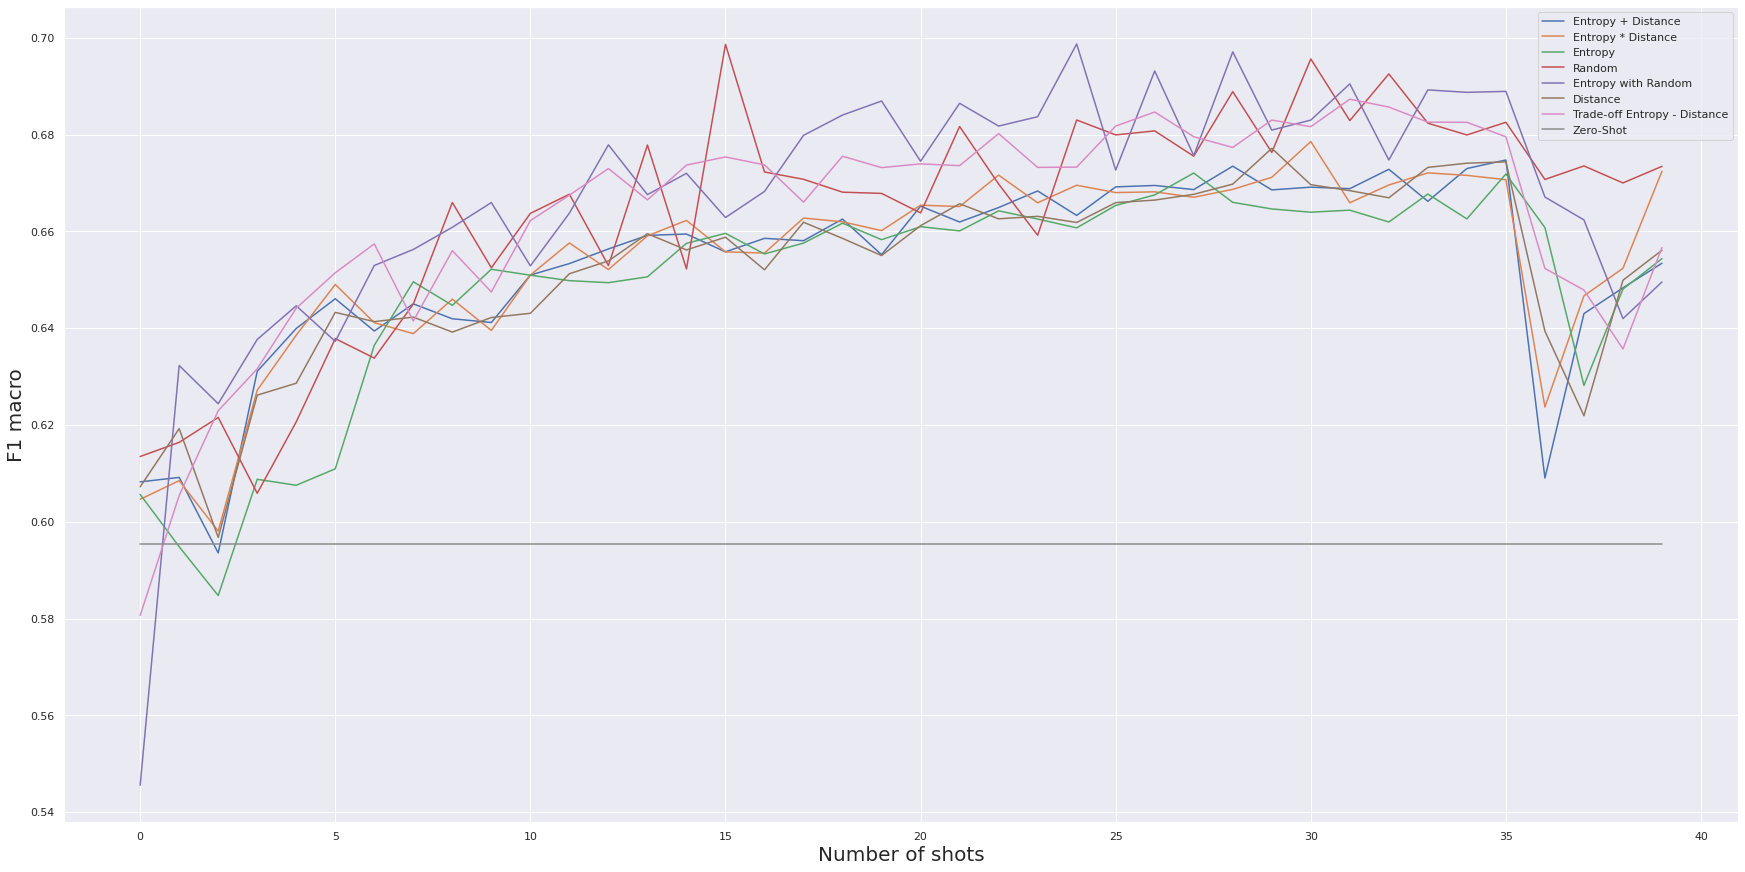

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
EpD = [0.6082438190427951, 0.6091669022964835, 0.5935595889471333, 0.6310817928381799, 0.6399411478441063, 0.6460812364646499, 0.639414080305296, 0.6450271059362197, 0.641944138726972, 0.6411731302921855, 0.6509787275869839, 0.6533466544686605, 0.6563701395942884, 0.6591756557713552, 0.6594498932829123, 0.6557764686407858, 0.6585629522000777, 0.6580809677107963, 0.6625451774256919, 0.6551812546652792, 0.6652133954047716, 0.6619420337689336, 0.6649264364887287, 0.6683548305887108, 0.6633010990868533, 0.6691960849221362, 0.6694931242381549, 0.6686354723035536, 0.6734763901194688, 0.6685768999469144, 0.6691408537898377, 0.6688266270969617, 0.6728276642968007, 0.6662192543672221, 0.6729880795752201, 0.674753248527083, 0.6090457761074302, 0.6430143869215436, 0.6483316936573592, 0.6534281917877853]
E4D = [0.60463816974461, 0.6084961614920772, 0.5980712812565709, 0.6271745004973427, 0.6385663147898875, 0.6490334317008529, 0.6411421384346211, 0.6388724536485856, 0.6460009787779627, 0.6395373191523814, 0.6509760085486772, 0.6576097838853995, 0.6521166690925665, 0.6590696546510096, 0.6622723064559708, 0.6557751452441464, 0.6555199162417091, 0.6627591496782544, 0.661978611773085, 0.6601650924790717, 0.665419099855095, 0.6651345897275418, 0.6716236979425549, 0.6659146952278391, 0.6695345635050868, 0.6680251742136514, 0.6681723205110682, 0.6670499548995125, 0.6686855383635815, 0.6711713657467622, 0.6785701999181464, 0.6659246886549302, 0.6695883574033098, 0.6720913510129197, 0.671577326208535, 0.6706814456377775, 0.6237113946329026, 0.6466829496157761, 0.6523764445318048, 0.672433265173229]
E = [0.6056474144762211, 0.5948452094301236, 0.5847543163732761, 0.6087753094570225, 0.607542368931995, 0.6109406785331577, 0.63647335775377, 0.649591079719723, 0.6447240588425814, 0.6521733903791901, 0.6509464477853159, 0.6498212871331225, 0.6494043223171567, 0.650609855866648, 0.6575300763531315, 0.6595952982696002, 0.6553371272082062, 0.6575887637623664, 0.6616942438336173, 0.6582903573496711, 0.6609699907500376, 0.6600990104622667, 0.664247206973202, 0.6625554836976965, 0.6607279381169325, 0.6653600076532314, 0.6675346686667029, 0.672059718701755, 0.6660015700669332, 0.6646379758493853, 0.6639623750944157, 0.6643884876634899, 0.6619402412872633, 0.6677138143167684, 0.6625864183561777, 0.6718551973806829, 0.6607920976144178, 0.628168007422523, 0.6480739991112151, 0.6543743720362781]
R = [0.6134839470775474, 0.6164094490002183, 0.6215565152175617, 0.6058911902824807, 0.6206534313195834, 0.6378439108841334, 0.63381942333982, 0.6449896616512004, 0.6659647585346492, 0.6524792172237216, 0.6637228197439125, 0.667678412350276, 0.6529342361963592, 0.6778412757036786, 0.6522482732508662, 0.6986512790326004, 0.6722758904025462, 0.6707632360594015, 0.6681051404997438, 0.6678501911485333, 0.6638168968053512, 0.6816707162938946, 0.6697933776669988, 0.6592052894297188, 0.6830203280130612, 0.6799371326495696, 0.680761943108828, 0.675540996958625, 0.6888784393974257, 0.6763130771917885, 0.6956345391541248, 0.6828909807950543, 0.6925397212336806, 0.6823607887155937, 0.6799240836380506, 0.6825440339815562, 0.6707349335435371, 0.6735256119094444, 0.6700107044924696, 0.6734417033577529]
M = [0.5455611385953091, 0.6322872456593567, 0.62439186947671, 0.6376759574845273, 0.6446237141521357, 0.6372612421692451, 0.652957177618884, 0.6562686579549463, 0.6608503691390732, 0.665956481005437, 0.6528760318499875, 0.6637721014795649, 0.6778841598201509, 0.6675888862217454, 0.6719998883858095, 0.6628640467600077, 0.6682595035255158, 0.679845204724905, 0.6840397710676408, 0.6869375067959506, 0.6744923638413488, 0.6864698649590075, 0.6817620426842159, 0.6836948340599367, 0.6987280454090943, 0.6726734297798272, 0.6931491118539442, 0.6756550963274648, 0.6970959698265415, 0.6809355802350758, 0.6830004450743931, 0.6904829747061301, 0.6747517340315824, 0.6892377846466576, 0.6887317896423836, 0.6889282238980622, 0.6671022494502508, 0.6623754755874645, 0.6419766967504892, 0.6495503978188825]
D = [0.607222654807283, 0.6192455939357867, 0.5967682889870682, 0.6261611920527084, 0.6286309855150046, 0.6432657888583316, 0.6413553323306328, 0.6422906774126549, 0.6391958897474124, 0.642206001455497, 0.6430766140003576, 0.6512437534435099, 0.6538973444335688, 0.6595221681564354, 0.6561666037235744, 0.6588044887495011, 0.652063571364051, 0.6618906728556533, 0.6585547301529578, 0.6550094262477463, 0.6611808014677498, 0.6657125353769813, 0.662599606135309, 0.6631121767433024, 0.6618404010872062, 0.6659432273854264, 0.6664674534164649, 0.6676616752609394, 0.6697675910957688, 0.6771556405324718, 0.6696494915186031, 0.6684204878057415, 0.6669425832565464, 0.6732235797272309, 0.6740878314975072, 0.6743694512636697, 0.6393873669503058, 0.6219125150383792, 0.6499078819251494, 0.6561110413141613]
T = [0.5806412650437027, 0.6054279461343322, 0.6229399151751747, 0.631608669545136, 0.6441368922374089, 0.6514514367914813, 0.65741906065918, 0.6414848604338734, 0.6560181490494112, 0.6474879517941229, 0.6622229726605335, 0.6674844948456633, 0.6729863912728087, 0.6665117937684627, 0.6736980561416497, 0.6753848665069432, 0.673745337600854, 0.6660459567301087, 0.6755275063321583, 0.6731803079962747, 0.6739519825431233, 0.6735874831554173, 0.68021072599931, 0.6732250352443547, 0.6732803708598548, 0.6817619250991215, 0.6846686006308211, 0.6795625067557183, 0.677344143608244, 0.683001685991114, 0.6816338541412877, 0.6873143745488474, 0.6856923932110883, 0.6825685085323135, 0.6825409897508179, 0.6795522975293673, 0.6523418921022236, 0.6478762436409148, 0.6356973024905049, 0.6566664692920555]
Z = [0.595435101251867]*40
sns.set()
plt.figure(figsize=(30, 15))
plt.plot(EpD)
plt.plot(E4D)
plt.plot(E)
plt.plot(R)
plt.plot(M)
plt.plot(D)
plt.plot(T)
plt.plot(Z)
plt.xlabel("Number of shots", fontsize = 20)
plt.ylabel("F1 macro", fontsize = 20)
plt.legend(labels=["Entropy + Distance","Entropy * Distance", "Entropy", "Random", "Entropy with Random", "Distance", "Trade-off Entropy - Distance", "Zero-Shot"])
plt.savefig('Results.eps', format='eps')
plt.show()

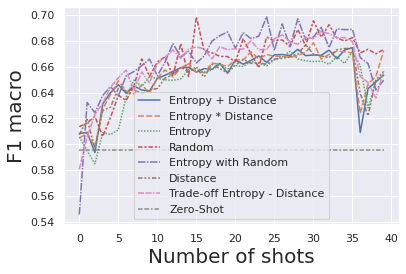

In [113]:
results = pd.DataFrame({"E+D": [0.6082438190427951, 0.6091669022964835, 0.5935595889471333, 0.6310817928381799, 0.6399411478441063, 0.6460812364646499, 0.639414080305296, 0.6450271059362197, 0.641944138726972, 0.6411731302921855, 0.6509787275869839, 0.6533466544686605, 0.6563701395942884, 0.6591756557713552, 0.6594498932829123, 0.6557764686407858, 0.6585629522000777, 0.6580809677107963, 0.6625451774256919, 0.6551812546652792, 0.6652133954047716, 0.6619420337689336, 0.6649264364887287, 0.6683548305887108, 0.6633010990868533, 0.6691960849221362, 0.6694931242381549, 0.6686354723035536, 0.6734763901194688, 0.6685768999469144, 0.6691408537898377, 0.6688266270969617, 0.6728276642968007, 0.6662192543672221, 0.6729880795752201, 0.674753248527083, 0.6090457761074302, 0.6430143869215436, 0.6483316936573592, 0.6534281917877853],
                    "E4D" : [0.60463816974461, 0.6084961614920772, 0.5980712812565709, 0.6271745004973427, 0.6385663147898875, 0.6490334317008529, 0.6411421384346211, 0.6388724536485856, 0.6460009787779627, 0.6395373191523814, 0.6509760085486772, 0.6576097838853995, 0.6521166690925665, 0.6590696546510096, 0.6622723064559708, 0.6557751452441464, 0.6555199162417091, 0.6627591496782544, 0.661978611773085, 0.6601650924790717, 0.665419099855095, 0.6651345897275418, 0.6716236979425549, 0.6659146952278391, 0.6695345635050868, 0.6680251742136514, 0.6681723205110682, 0.6670499548995125, 0.6686855383635815, 0.6711713657467622, 0.6785701999181464, 0.6659246886549302, 0.6695883574033098, 0.6720913510129197, 0.671577326208535, 0.6706814456377775, 0.6237113946329026, 0.6466829496157761, 0.6523764445318048, 0.672433265173229],
                    "E" : [0.6056474144762211, 0.5948452094301236, 0.5847543163732761, 0.6087753094570225, 0.607542368931995, 0.6109406785331577, 0.63647335775377, 0.649591079719723, 0.6447240588425814, 0.6521733903791901, 0.6509464477853159, 0.6498212871331225, 0.6494043223171567, 0.650609855866648, 0.6575300763531315, 0.6595952982696002, 0.6553371272082062, 0.6575887637623664, 0.6616942438336173, 0.6582903573496711, 0.6609699907500376, 0.6600990104622667, 0.664247206973202, 0.6625554836976965, 0.6607279381169325, 0.6653600076532314, 0.6675346686667029, 0.672059718701755, 0.6660015700669332, 0.6646379758493853, 0.6639623750944157, 0.6643884876634899, 0.6619402412872633, 0.6677138143167684, 0.6625864183561777, 0.6718551973806829, 0.6607920976144178, 0.628168007422523, 0.6480739991112151, 0.6543743720362781], 
                    "R" : [0.6134839470775474, 0.6164094490002183, 0.6215565152175617, 0.6058911902824807, 0.6206534313195834, 0.6378439108841334, 0.63381942333982, 0.6449896616512004, 0.6659647585346492, 0.6524792172237216, 0.6637228197439125, 0.667678412350276, 0.6529342361963592, 0.6778412757036786, 0.6522482732508662, 0.6986512790326004, 0.6722758904025462, 0.6707632360594015, 0.6681051404997438, 0.6678501911485333, 0.6638168968053512, 0.6816707162938946, 0.6697933776669988, 0.6592052894297188, 0.6830203280130612, 0.6799371326495696, 0.680761943108828, 0.675540996958625, 0.6888784393974257, 0.6763130771917885, 0.6956345391541248, 0.6828909807950543, 0.6925397212336806, 0.6823607887155937, 0.6799240836380506, 0.6825440339815562, 0.6707349335435371, 0.6735256119094444, 0.6700107044924696, 0.6734417033577529],  
                    "M" : [0.5455611385953091, 0.6322872456593567, 0.62439186947671, 0.6376759574845273, 0.6446237141521357, 0.6372612421692451, 0.652957177618884, 0.6562686579549463, 0.6608503691390732, 0.665956481005437, 0.6528760318499875, 0.6637721014795649, 0.6778841598201509, 0.6675888862217454, 0.6719998883858095, 0.6628640467600077, 0.6682595035255158, 0.679845204724905, 0.6840397710676408, 0.6869375067959506, 0.6744923638413488, 0.6864698649590075, 0.6817620426842159, 0.6836948340599367, 0.6987280454090943, 0.6726734297798272, 0.6931491118539442, 0.6756550963274648, 0.6970959698265415, 0.6809355802350758, 0.6830004450743931, 0.6904829747061301, 0.6747517340315824, 0.6892377846466576, 0.6887317896423836, 0.6889282238980622, 0.6671022494502508, 0.6623754755874645, 0.6419766967504892, 0.6495503978188825],
                    "D" : [0.607222654807283, 0.6192455939357867, 0.5967682889870682, 0.6261611920527084, 0.6286309855150046, 0.6432657888583316, 0.6413553323306328, 0.6422906774126549, 0.6391958897474124, 0.642206001455497, 0.6430766140003576, 0.6512437534435099, 0.6538973444335688, 0.6595221681564354, 0.6561666037235744, 0.6588044887495011, 0.652063571364051, 0.6618906728556533, 0.6585547301529578, 0.6550094262477463, 0.6611808014677498, 0.6657125353769813, 0.662599606135309, 0.6631121767433024, 0.6618404010872062, 0.6659432273854264, 0.6664674534164649, 0.6676616752609394, 0.6697675910957688, 0.6771556405324718, 0.6696494915186031, 0.6684204878057415, 0.6669425832565464, 0.6732235797272309, 0.6740878314975072, 0.6743694512636697, 0.6393873669503058, 0.6219125150383792, 0.6499078819251494, 0.6561110413141613],
                    "Tradeoff" : [0.5806412650437027, 0.6054279461343322, 0.6229399151751747, 0.631608669545136, 0.6441368922374089, 0.6514514367914813, 0.65741906065918, 0.6414848604338734, 0.6560181490494112, 0.6474879517941229, 0.6622229726605335, 0.6674844948456633, 0.6729863912728087, 0.6665117937684627, 0.6736980561416497, 0.6753848665069432, 0.673745337600854, 0.6660459567301087, 0.6755275063321583, 0.6731803079962747, 0.6739519825431233, 0.6735874831554173, 0.68021072599931, 0.6732250352443547, 0.6732803708598548, 0.6817619250991215, 0.6846686006308211, 0.6795625067557183, 0.677344143608244, 0.683001685991114, 0.6816338541412877, 0.6873143745488474, 0.6856923932110883, 0.6825685085323135, 0.6825409897508179, 0.6795522975293673, 0.6523418921022236, 0.6478762436409148, 0.6356973024905049, 0.6566664692920555],
                    "Zero-shot" : [0.595435101251867]*40})

p = sns.lineplot(data = results)
p.set_xlabel("Number of shots", fontsize = 20)
p.set_ylabel("F1 macro", fontsize = 20)
plt.legend(labels=["Entropy + Distance","Entropy * Distance", "Entropy", "Random", "Entropy with Random", "Distance", "Trade-off Entropy - Distance", "Zero-Shot"])

### Finetune the sentence transformer



In [27]:
from transformers import AutoTokenizer, AutoModel
from torch import nn
class TextEncoder(nn.Module):
    def __init__(self, device, model_name: str = 'sentence-transformers/all-mpnet-base-v2') -> None:
        super(TextEncoder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

    # def forward(self, text: Union[str, List[str]]) -> Tensor:
    def forward(self, text) -> torch.Tensor:
        inp = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        inp = inp.to(device)
        out = self.model(**inp)[0]  # First element of model_output contains all token embeddings.
        out = self.mean_pooling(out, inp['attention_mask'])
        if isinstance(text, str):  # If input is just 1 string -> return 1D embeddings.
            out = out.squeeze(0)
        return nn.functional.normalize(out, p=2, dim=-1)

    def mean_pooling(self, token_embeddings, attention_mask):
        input_mask_expanded = \
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [28]:
class complete_model_finetuning(nn.Module):
  def __init__(self, sentence_transformer_model, st_embedding_dimension, num_classes, device):
    super().__init__()
    self.st = TextEncoder(device, sentence_transformer_model)
    self.device = device
    self.to(device)

  def forward(self, documents):
    docs = self.st(documents) # assign a score to each class for every document
    return docs

In [34]:
import torch.optim as optim
from torch.utils.data import DataLoader

finetuned_model = complete_model_finetuning('sentence-transformers/all-mpnet-base-v2', 768, 768, device)
lr = 1e-5
epochs = 9
batch_size = 128

criterion = NContrastiveLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)

training_documents = document_class(dataframes['Abstract'], dataframes['Domain'])
training_dataloader = DataLoader(training_documents, batch_size=batch_size, shuffle=True)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
writer = SummaryWriter()
best_eval_loss = np.inf

for epoch in range(epochs):

  training_loss = 0

  finetuned_model.train()

  for batch, (training_labels, docs) in enumerate(training_dataloader):
    document_embeddings = finetuned_model(list(docs))
    positives = finetuned_model(list(training_labels))
    negatives = []
    for idx in range(len(positives)):
      x = torch.cat((positives[:idx],positives[idx+1:]))
      negatives.append(x)
    negatives = torch.stack(negatives)
    loss = criterion(document_embeddings, positives, negatives)
    optimizer.zero_grad()
    loss.backward()
    training_loss += loss
    optimizer.step()

    print(f'Batch: {batch}/{len(training_dataloader)}, epoch: {epoch}/{epochs}. Training loss: {training_loss:.3f}.')
  writer.add_scalar("Loss/epoch", training_loss, epoch+1)

  finetuned_model.eval()
  tmp_test_document_embeddings = []

with torch.no_grad():
  label_embeddings = finetuned_model(labels)

test_dataloader = DataLoader(list(test_docs), batch_size=32, shuffle=False)
for test_doc in tqdm(test_dataloader):
  with torch.no_grad():
    embs = finetuned_model(test_doc)
  tmp_test_document_embeddings.extend(embs)

test_document_embeddings = torch.stack(tmp_test_document_embeddings)
knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
knn.fit(label_embeddings.cpu(), labels)
y_pred = knn.predict(test_document_embeddings.cpu())
F1 = f1_score(test_labels, y_pred, average='macro')
print(f'Epoch: {epoch}, F1 macro: {F1}')

#writer.add_scalar("F1_macro/epoch", F1, epoch+1)

writer.flush()

Batch: 0/1, epoch: 0/9. Training loss: 1.866.
Batch: 0/1, epoch: 1/9. Training loss: 1.840.
Batch: 0/1, epoch: 2/9. Training loss: 1.793.
Batch: 0/1, epoch: 3/9. Training loss: 1.783.
Batch: 0/1, epoch: 4/9. Training loss: 1.718.
Batch: 0/1, epoch: 5/9. Training loss: 1.687.
Batch: 0/1, epoch: 6/9. Training loss: 1.655.
Batch: 0/1, epoch: 7/9. Training loss: 1.623.
Batch: 0/1, epoch: 8/9. Training loss: 1.590.


 65%|██████▍   | 190/294 [06:25<03:26,  1.99s/it]

In [ ]:
!pip install tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs

## Supervised

In [ ]:
from tqdm import tqdm
def predict(model, data, batch_size, device):
  model.to(device)
  model.eval()
  dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, collate_fn=my_collate_fn)
  y_pred = []
  for docs, _ in tqdm(dataloader):
    with torch.no_grad():
      y_pred.extend(model(docs).cpu().numpy())
  return y_pred

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
integer_labels = le.fit_transform(labels)

int_top_1_labels = le.transform(dataframes['Domain'])

ohe = OneHotEncoder(sparse=False)
ohe.fit(integer_labels.reshape(-1,1))

ohe_top_1_labels = ohe.transform(int_top_1_labels.reshape(-1,1)) # (32889, 7)

In [ ]:
int_test_labels = le.transform(test_labels)
ohe_test_labels = ohe.transform(int_test_labels.reshape(-1,1)) # (9398, 7)

test_documents = document_class(test_docs, ohe_test_labels)

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

supervised_model = Classifier('sentence-transformers/all-mpnet-base-v2', 768, len(labels), device)

lr = 1e-2
epochs = 2
batch_size = 256

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, supervised_model.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)

training_documents = document_class(dataframes['Abstract'], ohe_top_1_labels)
training_dataloader = DataLoader(training_documents, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
writer = SummaryWriter()
best_eval_loss = np.inf
for epoch in range(epochs):

  training_loss = 0

  supervised_model.train()

  for batch, (docs, training_labels) in enumerate(training_dataloader):
    training_labels = training_labels.to(device)

    probabilities = supervised_model(docs)
    loss = criterion(probabilities, training_labels)
    training_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Batch: {batch}/{len(training_dataloader)}, epoch: {epoch}/{epochs}. Training loss: {training_loss:.3f}.')
    writer.add_scalar("Loss/epoch", training_loss, epoch+1)

  supervised_model.eval()
  y_pred = predict(supervised_model, test_documents, 256, device)
  F1 = f1_score(int_test_labels, np.argmax(np.asarray(y_pred), axis = 1), average='macro')
  print(f'Epoch: {epoch}, F1 macro: {F1}')

  writer.add_scalar("F1_macro/epoch", F1, epoch+1)

writer.flush()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs